# Deep Style

Deep style is an interesting deep learning model. It can extract the style of an image and apply it to another image. On the implementation side, it combines the style weights of an image and the content weights of another one from the specific layers of VGG19.
In this notebook, we will build it on hand.

## Parameters

As you see, we will take the second convolution layer of block five from VGG19 as the content layer, and the first convolution layer from blocks one to five as style layers.
You can adjust the ratio of style weight and content weight. Check out what will be different.

In [1]:
import os
import time
import PIL.Image
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from typing import Union
import matplotlib.pyplot as plt
import IPython.display as display

mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 12)
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

EPOCHS = 100
STEPS = 20

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)
style_weight = 0.3
content_weight = 1

## Functions


Here are functions for image preparation and processing.

In [2]:
# load image
def load_img(img_path:str) -> tf.Tensor:
    """
    Load image.
        img_path: image path
    """
    max_dim = 600
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=0)
    image_max_dim = max(image.shape)
    if image_max_dim > max_dim:
        scale = max_dim / image_max_dim
        image = tf.image.resize(image, tf.cast(tf.math.multiply(tf.cast(tf.shape(image)[1:3], tf.float32), scale), tf.int32))
    image = image / 255
    return image


# show image
def imshow(image:tf.Tensor, title:str = None) -> None:
    """
    Display image.
        image: image tensor
        title: image title
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# tensor to image
def tensor_to_image(tensor:tf.Tensor) -> PIL.Image:
    """
    Transform tensor to image.
        tensor: tensorflow tensor
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# read content, style images
def read_material_images(content_path:str, style_path:str) -> Union[tf.Tensor, tf.Tensor]:
    """
    Read and display material images.
        content_path: content image path
        style_path: style image path
    """
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    plt.figure(figsize=(10, 5), dpi=80)
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
    return content_image, style_image

# get the specific layers what we need
def vgg_layers(layer_names:list) -> tf.keras.models.Model:
    """
    Load a vgg model return a list of intermediate output values.
        layer_names: the intermediate layers' name you want to get their values
    """
    # load vgg model
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    # get layers' outputs by their names
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # create a new vgg model would return the outputs you want
    model = tf.keras.Model(vgg.input, outputs)
    return model

# rescale a iamge
def clip_0_1(image: tf.Tensor) -> tf.Tensor:
    """
    Rescale image pixel values between specific range.
        image: tensorflow tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Image

The content image is a temple called '清水寺' in Japan.  
The style image is '神奈川沖浪裏' a famous painting.

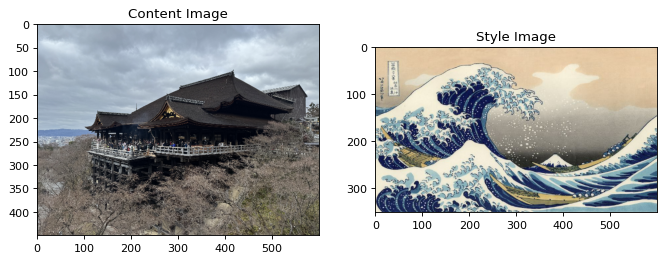

In [3]:
content_image, style_image = read_material_images('./drive/MyDrive/Deep_Style/content/content1.png', './drive/MyDrive/Deep_Style/style/style1.jpeg')

## Model

In [4]:
class DeepStyleModel(tf.keras.models.Model):
    def __init__(self, content_layers:list, style_layers:list) -> None:
        """
        Create a deep style model.
            style_layers: vgg intermediate layers' name for style layer
            content_layers: vgg intermediate layers' name for content layer
        """
        super(DeepStyleModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        self.content_weight = content_weight
        self.style_weight = style_weight

    def image_extract(self, inputs:tf.Tensor) -> dict:
        """
        Input image then extract its vgg intermediate output values.
            inputs: content image or style image
        """
        inputs = inputs * 255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        content_dict = [i for i in content_outputs]
        style_dict = [i for i in style_outputs]
        return {'content': content_dict, 'style': style_dict}

    def generate_target(self, content_image:tf.Tensor, style_image:tf.Tensor) -> None:
        """
        Generate target values for gradient descent.
            content_image: content image
            style_image: style image
        """
        self.content_targets = self.image_extract(content_image)['content']
        self.style_targets = self.image_extract(style_image)['style']

    def gram_matrix(self, input_tensor:tf.Tensor) -> tf.Tensor:
        """
        Calculate gram matrix of style layer outputs.
            input_tensor: style layer
        """
        result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        return result

    def style_tensor_loss(self, tensor_result: tf.Tensor, target_result:tf.Tensor) -> tf.Tensor:
        """
        Calculate style tensor loss.
            tensor_result: style tensor values
            target_result: style tensor target values
        """
        result_width, result_length, result_channel = tf.shape(tensor_result)[1], tf.shape(tensor_result)[2], tf.shape(tensor_result)[3]
        style_result = self.gram_matrix(tensor_result)
        target_result = self.gram_matrix(target_result)
        tensor_loss = tf.reduce_sum((style_result - target_result) ** 2) / (2 * tf.cast(result_width * result_length * result_channel, tf.float32)) ** 2
        return tensor_loss

    def content_tensor_loss(self, tensor_result:tf.Tensor, target_result:tf.Tensor) -> tf.Tensor:
        """
        Calculate content tensor loss.
            tensor_result: content tensor values
            target_result: content tensor target values
        """
        tensor_loss = tf.reduce_sum((tensor_result - target_result) ** 2) / 2
        return tensor_loss

    def style_content_loss(self, outputs:tf.Tensor, style_target:tf.Tensor, content_target:tf.Tensor, weights:list=1) -> Union[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Calculate total loss for gradient descent.
            outputs: the vgg intermediate layer outputs of training image
            style_target: style tensor values
            content_target: content tensor values
            weights: weights list for each style layer
        """
        style_outputs, content_outputs = outputs['style'], outputs['content']
        style_loss = [self.style_tensor_loss(style_result, target_result) for style_result, target_result in zip(style_outputs, style_target)]
        # style_loss = tf.reduce_sum([l * w for l, w in zip(style_loss, weights)])
        style_loss = tf.reduce_sum(style_loss)

        content_loss = [self.content_tensor_loss(content_result, target_result) for content_result, target_result in zip(content_outputs, content_target)]
        content_loss = tf.reduce_sum(content_loss)
        loss = style_loss * self.style_weight + content_loss * self.content_weight
        return loss, style_loss, content_loss

    @tf.function()
    def train_step(self, image:tf.Tensor) -> Union[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Calculate gradient descent of deep style model and renew image values.
            image: training image
        """
        with tf.GradientTape() as tape:
            outputs = self.image_extract(image)
            loss, style_loss, content_loss = self.style_content_loss(outputs, self.style_targets, self.content_targets)
        grad = tape.gradient(loss, image)
        optimizer.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
        return loss, style_loss, content_loss

    def train(self, image:tf.Tensor, steps:int) -> None:
        """
        Train deep style model.
            image: training image
            steps: the number of training step for each epoch
        """
        start_time = time.time()
        for _ in range(1, steps+1):
            loss, style_loss, content_loss = self.train_step(image)
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print(f'Training time of one epoch is {time.time() - start_time} sec')
        print(f'Model Loss: {loss}, Style Loss: {style_loss}, Content Loss: {content_loss}')


## Training

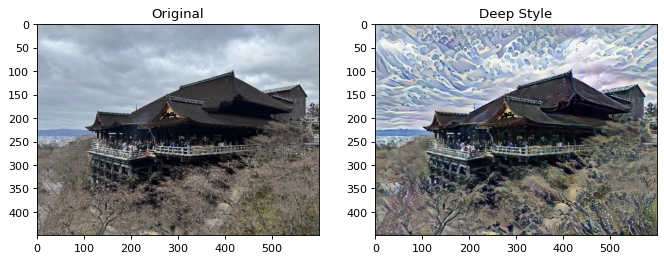

In [5]:
DS_MODEL = DeepStyleModel(content_layers, style_layers)

DS_MODEL.generate_target(content_image, style_image)

# create training image, use content_image as initiated image
image = tf.Variable(content_image)

image_no = 1
# training
for epoch in range(1, EPOCHS + 1):
    DS_MODEL.train(image, STEPS)

display.clear_output(wait=True)
plt.figure(figsize=(10, 5), dpi=80)
plt.subplot(1, 2, 1)
imshow(content_image, 'Original')
plt.subplot(1, 2, 2)
imshow(image, 'Deep Style')

## Image2

The content image is 'Tivoli' amusement park in Denmark.  
The style image is 'Café Terrace at Night' by Van Gogh in 1888.

I change the learning rate and the style-content ratio.

In [6]:
optimizer = tf.optimizers.Adam(learning_rate=0.002, beta_1=0.99, epsilon=1e-1)
style_weight = 1
content_weight = 1

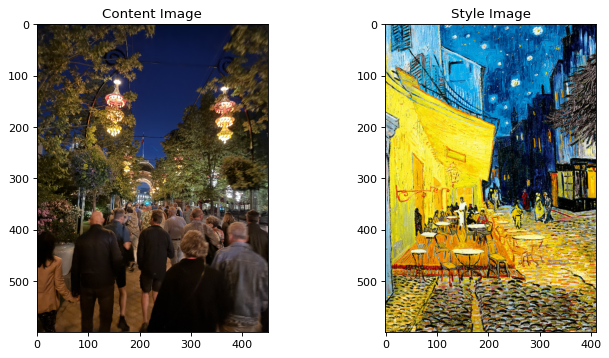

In [7]:
content_image, style_image = read_material_images('./drive/MyDrive/Deep_Style/content/content2.png', './drive/MyDrive/Deep_Style/style/style2.jpeg')

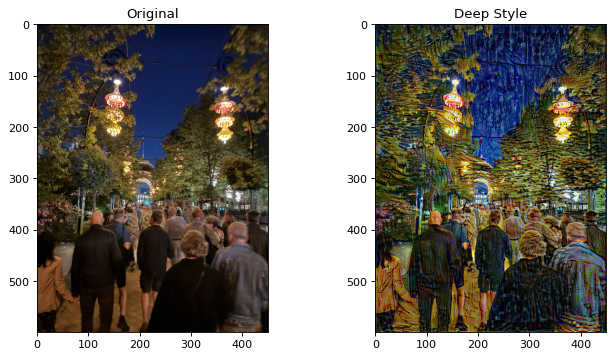

In [8]:
DS_MODEL = DeepStyleModel(content_layers, style_layers)

DS_MODEL.generate_target(content_image, style_image)

# create training image, use content_image as initiated image
image = tf.Variable(content_image)

image_no = 1
# training
for epoch in range(1, EPOCHS + 1):
    DS_MODEL.train(image, STEPS)

display.clear_output(wait=True)
plt.figure(figsize=(10, 5), dpi=80)
plt.subplot(1, 2, 1)
imshow(content_image, 'Original')
plt.subplot(1, 2, 2)
imshow(image, 'Deep Style')